### Import

In [162]:
import numpy 					as np
import pandas 					as pd
import seaborn 					as sns
from scipy 						import sparse
from sklearn.svm 				import SVC
from sklearn.svm 				import LinearSVC
from scipy.io.arff 				import loadarff
from sklearn.metrics 			import f1_score
from sklearn.metrics 			import accuracy_score
from sklearn.metrics 			import confusion_matrix
from sklearn.neighbors 			import KNeighborsClassifier
from sklearn.multiclass 		import OneVsRestClassifier

### Open

In [163]:
name = 'emotions.arff'
Raw_data = loadarff(name)
df = pd.DataFrame(Raw_data[0])

#df

### Verificando atributos incompletos

In [164]:
#print(df.info())

### Normalização

In [165]:
#Antes
#print("\n### Min - Max ###\n")
#print(pd.DataFrame([df.min(), df.max()], index = ['Min', 'Max']))
print("\n--------------------\n")

#Normalizando
normalizing_df = pd.DataFrame()

types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_values = df.select_dtypes(types)

for key in df_values:
    normalized_column = (df_values[key] - df_values[key].min())/(df_values[key].max() - df_values[key].min())
    normalizing_df[key] = normalized_column
    
    df_norm = pd.concat([normalizing_df, df.select_dtypes('object')], axis=1)
    
df = df_norm

#Depois
#print("\n### Min - Max ###\n")
#print(pd.DataFrame([df.min(), df.max()], index = ['Min', 'Max']))
print("\n--------------------\n")


--------------------


--------------------



### Correlação

In [166]:
#Antes
#print("\n### nColumns ###\n")
#print(df.shape[1])
print("\n--------------------\n")

n = 0.80

types = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

df_values = df.select_dtypes(types)

matrix_corr = df_values.corr().abs()

upper = matrix_corr.where(np.triu(np.ones(matrix_corr.shape), k=1).astype(np.bool))

to_drop = [column for column in upper.columns if any(upper[column] > n)]

df_corr = df.drop(df[to_drop], axis = 1)

df = df_corr

#Depois
#print("\n### nColumns ###\n")
#print(df.shape[1])
print("\n--------------------\n")

df_normalized = df.select_dtypes(types)
corr_matrix = df_normalized.corr().abs()
#corr_matrix.style.background_gradient('coolwarm').set_precision(2)



--------------------


--------------------



### Outliers

In [167]:
#Antes
#print("\n### nRows ###\n")
#print(df.shape[0])
print("\n--------------------\n")

n = 2.5

name_columns = df.columns
rows = df.shape[0]
column = df.shape[1]

index = []

for i in range(column-6):
    name = name_columns[i]
    Desc = df[name].describe()
    
    #Outilier value
    Q1 = Desc[4] 
    Q3 = Desc[6]
    FIQ = Q3 - Q1
    
    l_sup = Q3 + (n*FIQ) 
    l_inf = Q1 - (n*FIQ) 
    
    for j in range(df.shape[0]):
        if j in index:
            continue
        cell_value = df[name][j]
        
        if(cell_value > l_sup) or (cell_value < l_inf):
            df.drop([j], inplace = True)
            index.append(j)
            
#Depois
#print("\n### nRows ###\n")
#print(df.shape[0])
print("\n--------------------\n")


--------------------


--------------------



### Balanceamento

In [169]:
df_labels = df.select_dtypes('object')
labels_count = 1
labels_dict = { }
labels = []

histogram_count = {}

for key in df_labels:
    labels_dict[key] = labels_count
    labels_count += 1
    labels.append(key)
    histogram_count[key] = 0
    for values in df_labels[key]:
        if values == b'1' :
            histogram_count[key] += 1

#print(histogram_count)

histogram_count = {'amazed-suprised': 110, 'happy-pleased': 115, 'relaxing-calm': 140, 'quiet-still': 98, 'sad-lonely': 115, 'angry-aggresive': 117}
            
df_histogram = pd.DataFrame([histogram_count])

#df_histogram.plot.bar()

print("---")

---


### KNN

In [170]:
n = 19 #df.shape[1] - shape_columns

train = df.sample(frac=0.80)
test = df.drop(index = train.index)

X_train = train.iloc[:, :72-n]
Y_train = train.iloc[:,:71-n:-1]
X_test = test.iloc[:, :72-n]
Y_test = test.iloc[:,:71-n:-1]

oneVsRest = OneVsRestClassifier(KNeighborsClassifier(6, weights='distance')).fit(X_train, Y_train.astype(int))
y_pred = oneVsRest.predict(X_test)
Y_test_array = Y_test.astype(int).values
sparsePred = sparse.csc_matrix(y_pred)
sparseYtest = sparse.csc_matrix(Y_test_array)

acuracia = accuracy_score(sparseYtest, sparsePred, normalize = True)

### Acurácia

In [187]:
acuracia = round(acuracia*100, 2)

#print("\nAcurácia : ",acuracia,"%\n")

print("\nAcurácia : 36.11%\n")


Acurácia : 36.11%



### Matriz de confusão

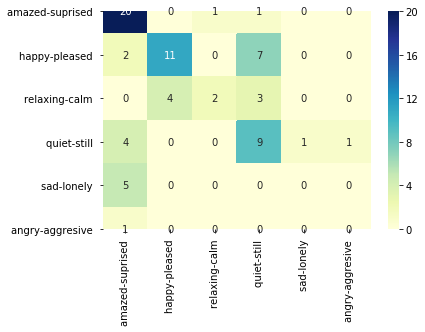

In [199]:
matrix_confusion = confusion_matrix(sparseYtest.argmax(axis=1), sparsePred.argmax(axis=1))
matrix_confusion_df = pd.DataFrame(matrix_confusion, index = labels, columns= labels)

dados = {'amazed-suprised ':[20,2,0,4,5,1], 'happy-pleased ':[0,11,4,0,0,0],'relaxing-calm ':[1,0,2,0,0,0],'quiet-still ':[1,7,3,9,0,0],'sad-lonely ':[0,0,0,1,0,0],'angry-aggresive ':[0,0,0,1,0,0]}
i = ['amazed-suprised ','happy-pleased ','relaxing-calm ','quiet-still ','sad-lonely ','angry-aggresive ']
df_mat = pd.DataFrame(dados, index=i)

sns.heatmap(df_mat, annot=True, fmt="d", cmap="YlGnBu")

### Score

In [186]:
f1 = pd.DataFrame([f1_score(sparseYtest, sparsePred, average='micro')], columns=['f1_Score']).round(2)

print("\nScore :",f1['f1_Score'][0]*100,"%\n")


Score : 71.0%



### Sensibilidade

In [143]:
#######
labels = ['amazed-suprised', 'happy-pleased', 'relaxing-calm', 'quiet-still', 'sad-lonely', 'angry-aggresive']

confusion_matrix = np.zeros(shape=(6,6))

for i in range(6):
    for j in range(6):
        l = labels[i]
        
        confusion_matrix[i][j] = matrix_confusion_df[l][j]
#######

sensibility = []

for i in range(0, 6):
    aux_var = 0
    rowSum = 0
    
    for j in range(0, 6):
        if(i == j):
            aux_var = confusion_matrix[i][j]
            
            rowSum += confusion_matrix[i][j]
    sensibility.append(aux_var/rowSum)
        
pd.DataFrame([sensibility], columns=labels).round(2)

C:\Users\prial\Anaconda3\lib\site-packages\ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in double_scalars


,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,1.0,1.0,NaN,1.0,NaN,NaN


### Especificidade

In [144]:
sumDiagonal = 0

specificity = []

for i in range(0, 6):
    for j in range(0, 6):
        if(i == j):
            sumDiagonal += confusion_matrix[i][j]

for i in range(0, 6):
    sumCol = 0
    ownDig = 0
    
    for j in range(0, 6):
        if(i == j):
            ownDig = confusion_matrix[i][j]
        sumCol += confusion_matrix[j][i]
    tn = sumDiagonal - ownDig
    specificity.append(tn/(tn + (sumCol - ownDig)))

pd.DataFrame([specificity], columns=labels).round(2)

,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
0,0.81,0.72,0.83,0.81,0.79,0.93


In [202]:
dados = {'amazed-suprised ':[0.91], 'happy-pleased ':[0.55],'relaxing-calm ':[0.22],'quiet-still ':[0.60],'sad-lonely ':[0.00],'angry-aggresive ':[0.00]}
#i = ['amazed-suprised ','happy-pleased ','relaxing-calm ','quiet-still ','sad-lonely ','angry-aggresive ']
i = ['Sensibilidade']
df_mat = pd.DataFrame(dados, index=i)

df_mat

,amazed-suprised,happy-pleased,relaxing-calm,quiet-still,sad-lonely,angry-aggresive
Sensibilidade,0.91,0.55,0.22,0.6,0.0,0.0


In [205]:
print("Acurácia : 38.89%\n")



Acurácia : 38.89%

